# Dog Breed Analysis
<div>
<img src="puppytraining.jpeg" width="400" height = "300"/>
</div>

1. Data cleaning
2. EDA
3. Recommendation System
    - Euclidian distance
    - PCA with K mean clustering
    - matrix factorization
4. Compare

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import Image, display

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


In [2]:
df = pd.read_csv("dog_data.csv")

In [3]:
df.head(1)
df.shape

(276, 30)

In [54]:
df.columns

Index(['Unnamed: 0', 'dog', 'height', 'weight', 'life_expectancy',
       'Affectionate With Family', 'Good With Young Children',
       'Good With Other Dogs', 'Shedding Level', 'Coat Grooming Frequency',
       'Drooling Level', 'Coat Type', 'Coat Length', 'Openness To Strangers',
       'Playfulness Level', 'Watchdog/Protective Nature', 'Adaptability Level',
       'Trainability Level', 'Energy Level', 'Barking Level',
       'Mental Stimulation Needs', 'popularity_rank', 'color', 'marking',
       'breed_info', 'health', 'grooming', 'excercise', 'training',
       'nutrition'],
      dtype='object')

### 1. Data Cleaning
#### cleaning height, weight, life expectancy and poplarity ranking

In [55]:
# Let's do data cleaning for height, weight, life expectancy, popularity ranking
def is_number(string):
    try:
        float(string)
        return True
    except ValueError:
        return False

def hwl_clean(height): # height weight life clean
    height = str(height)
    height_list = height.split('-')
    result = []
    for word in height_list:
        result = result + word.split(" ")
    avg_val = 0
    count = 0
    for i in result:
        if is_number(i):
            count = count +1
            avg_val = avg_val + float(i)
    if count != 0:
        avg_val = avg_val / count
        return avg_val
    else:
        return 0

df['height_c'] = df['height'].apply(hwl_clean)
df['weight_c'] = df['weight'].apply(hwl_clean)
df['life_c'] = df['life_expectancy'].apply(hwl_clean)

# replace the outlier with the mean value
mean_val = (df["life_c"].sum() - df["life_c"].max()) / 275
df["life_c"].replace(df["life_c"].max(), mean_val, inplace= True)

df.drop(['height','weight','life_expectancy'], axis = 1,inplace = True)

In [56]:
df[['height_c','weight_c','life_c']].isnull().sum()
# we are missing 10,20,2 values from height, weight and life respectively

height_c    10
weight_c    20
life_c       2
dtype: int64

#### cleaning popularity

In [57]:
# Let's do data cleaning for popularity
def popular_clean(pop):
    if type(pop) == float:
        return np.nan
    else:
        rank_list = pop.split(" of ")
        measure = int(rank_list[0]) / int(rank_list[1])
        return 1 - measure

df['popularity_rank_c']= df['popularity_rank'].apply(popular_clean)
df.drop('popularity_rank', axis = 1, inplace = True)
df['Coat Length'].value_counts()

Short           121
Medium          104
Long             37
Short-Medium      6
Medium-Long       3
Short-Long        1
Name: Coat Length, dtype: int64

#### cleaning coat length. minize the categories to long, medium and short then change it to numeric value.

In [58]:
# Coat Length has to be cleaned
df[df['Coat Length'] == 'Short-Long']
def coatLen_clean(coat):
    if type(coat) != float:
        if "Long" in coat:
            return 3
        elif "Medium" in coat:
            return 2
        else:
            return 1
    else:
        return np.nan

df["Coat_Length_c"] = df["Coat Length"].apply(coatLen_clean)
df.drop("Coat Length", axis = 1, inplace= True)

#### Cleaning coat type

In [59]:
coat_dict = {}
for i in df["Coat Type"]:
    if type(i) != float:
        coat_list = i.split('-')
        for coat in coat_list:
            if coat not in coat_dict:
                coat_dict[coat] = 1
            else:
                coat_dict[coat] = coat_dict[coat] + 1

new_dict = dict(sorted(coat_dict.items(), key=lambda item: item[1], reverse= True))
new_dict

{'Double': 130,
 'Smooth': 102,
 'Wiry': 35,
 'Wavy': 25,
 'Silky': 21,
 'Curly': 17,
 'Rough': 11,
 'Corded': 4,
 'Hairless': 3}

In [60]:
def coat_clean(coat):
    if type(coat) != float:
        if 'Double' in coat:
            return 'Double'
        elif 'Smooth' in coat:
            return 'Smooth'
        elif 'Wiry' in coat:
            return 'Wiry'
        elif 'Silky' in coat:
            return 'Silky'
        elif 'Curly' in coat:
            return 'Curly'
        elif 'Rough' in coat:
            return 'Rough'
        elif 'Corded' in coat:
            return 'Corded'
        elif 'Hairless' in coat:
            return 'Hairless'
    else:
        return np.nan
df['coat_c'] = df['Coat Type'].apply(coat_clean)
df.drop("Coat Type", axis = 1, inplace = True)
df.drop("marking", axis = 1, inplace = True)
df.drop("color", axis = 1, inplace = True)

In [61]:
# reorganize in the way that I like to see

df = df[['dog','popularity_rank_c','height_c', 'weight_c', 'life_c','Coat_Length_c', 'coat_c','Affectionate With Family',
       'Good With Young Children', 'Good With Other Dogs', 'Shedding Level',
       'Coat Grooming Frequency', 'Drooling Level', 'Openness To Strangers',
       'Playfulness Level', 'Watchdog/Protective Nature', 'Adaptability Level',
       'Trainability Level', 'Energy Level', 'Barking Level',
       'Mental Stimulation Needs', 'breed_info', 'health', 'grooming',
       'excercise', 'training', 'nutrition']]

### 2. EDA
#### 1) histogram for qunatative data
#### 2) histogram for categorical data

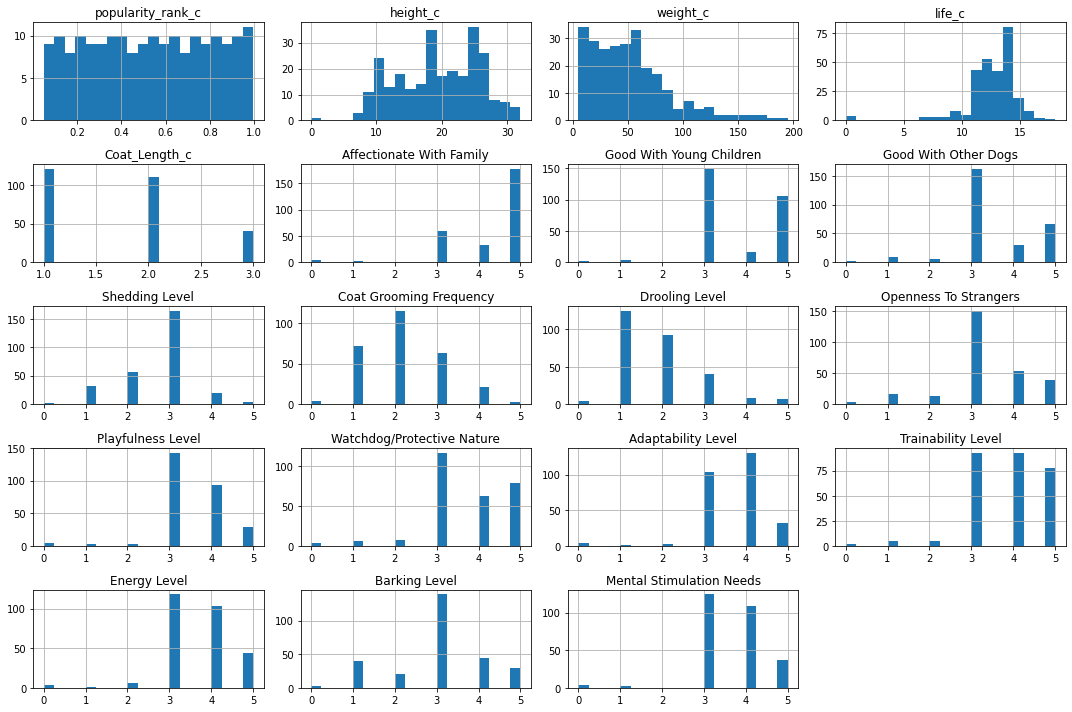

In [62]:
df.hist(bins = 20, figsize = (15,10))
plt.tight_layout()
plt.show()

In [63]:
# from the histogram above, we can see that there are outliers with value 0. Let's replace 0 with mean value

def replace_w_mean(df,col,val2replace):
    count_of_val = df[df[col] == val2replace][col].count()
    mean_val = (df[col].sum() - val2replace * count_of_val) / (df[col].count() - count_of_val)
    df[col].replace(val2replace,mean_val,inplace = True)

numeric_columns = list(df.select_dtypes(include=[np.number]).columns)
for col in numeric_columns:
    print(col)
    replace_w_mean(df,col,0)


popularity_rank_c
height_c
weight_c
life_c
Coat_Length_c
Affectionate With Family
Good With Young Children
Good With Other Dogs
Shedding Level
Coat Grooming Frequency
Drooling Level
Openness To Strangers
Playfulness Level
Watchdog/Protective Nature
Adaptability Level
Trainability Level
Energy Level
Barking Level
Mental Stimulation Needs


In [64]:
# numeric_data = df.select_dtypes(include=[np.number])
# categorical_data = df.select_dtypes(exclude=[np.number])
# list(categorical_data.columns)

### 3. Recommendation System
#### Let me start with the most obivous way. "Euclidean distance Recommendation system"
#### there are two ways to use this recommendation system
##### 1) choose the dog you like -> recommend the five other dogs that is similar with the dog you chose
##### 2) answer question about the traits -> recommend the five other dogs that is similar with the dog you chose

In [65]:
# let's choose what columns to include for the eudlidean distance recommendation system
df.columns

Index(['dog', 'popularity_rank_c', 'height_c', 'weight_c', 'life_c',
       'Coat_Length_c', 'coat_c', 'Affectionate With Family',
       'Good With Young Children', 'Good With Other Dogs', 'Shedding Level',
       'Coat Grooming Frequency', 'Drooling Level', 'Openness To Strangers',
       'Playfulness Level', 'Watchdog/Protective Nature', 'Adaptability Level',
       'Trainability Level', 'Energy Level', 'Barking Level',
       'Mental Stimulation Needs', 'breed_info', 'health', 'grooming',
       'excercise', 'training', 'nutrition'],
      dtype='object')

In [66]:
# let's choose 
euclidean_cols = ['height_c', 'weight_c', 'life_c',
       'Coat_Length_c', 'Affectionate With Family',
       'Good With Young Children', 'Good With Other Dogs', 'Shedding Level',
       'Coat Grooming Frequency', 'Drooling Level', 'Openness To Strangers',
       'Playfulness Level', 'Watchdog/Protective Nature', 'Adaptability Level',
       'Trainability Level', 'Energy Level', 'Barking Level',
       'Mental Stimulation Needs']
df_euclidean = df[euclidean_cols]

In [67]:
# Now let's normalize the dataset
df_euclidean.fillna(df_euclidean.mean(), inplace = True)
normalized_df_euclidean=(df_euclidean-df_euclidean.min())/(df_euclidean.max()-df_euclidean.min())
normalized_df_euclidean

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,height_c,weight_c,life_c,Coat_Length_c,Affectionate With Family,Good With Young Children,Good With Other Dogs,Shedding Level,Coat Grooming Frequency,Drooling Level,Openness To Strangers,Playfulness Level,Watchdog/Protective Nature,Adaptability Level,Trainability Level,Energy Level,Barking Level,Mental Stimulation Needs
0,0.147059,0.018421,0.608696,0.5,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,1.000000,0.500000,0.500000,0.750000,0.500000,0.500000,0.500000,0.500000
1,0.764706,0.263158,0.739130,1.0,0.500000,0.500000,0.500000,0.000000,0.750000,0.000000,0.500000,0.500000,0.500000,0.500000,0.000000,0.750000,0.500000,0.500000
2,0.647059,0.289474,0.521739,0.5,0.500000,0.500000,0.500000,0.000000,0.500000,0.000000,0.500000,0.500000,1.000000,0.500000,0.500000,0.500000,0.500000,0.500000
3,0.803922,0.578947,0.478261,0.5,0.500000,0.500000,0.000000,0.500000,0.500000,0.000000,0.250000,0.500000,1.000000,0.500000,0.500000,0.750000,0.250000,0.500000
4,0.254902,0.250442,0.695652,0.5,0.500000,0.500000,1.000000,0.500000,0.500000,0.000000,0.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,0.470588,0.223684,0.608696,0.5,1.000000,1.000000,0.750000,0.500000,0.250000,0.250000,0.000000,0.500000,0.500000,0.750000,1.000000,0.750000,0.500000,0.750000
272,0.333333,0.078947,0.608696,0.5,1.000000,1.000000,0.500000,0.250000,0.500000,0.250000,1.000000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000
273,0.176471,0.065789,0.652174,0.5,1.000000,1.000000,0.500000,0.500000,0.500000,0.000000,0.750000,1.000000,1.000000,0.750000,0.500000,0.750000,1.000000,0.750000
274,0.647059,0.302632,0.565217,0.5,0.848346,0.698905,0.624088,0.414234,0.286765,0.205882,0.577206,0.631434,0.683824,0.672794,0.713504,0.668498,0.502737,0.661765


In [21]:

def get_idx(df,dog_name):
    return df[df['dog']== dog_name].index.to_list()[0]

def get_names(df,dog_name):
    dist_list = []
    for i in range(df.shape[0]):
        dist_list.append(np.linalg.norm(normalized_df_euclidean.iloc[get_idx(df,dog_name)]-normalized_df_euclidean.iloc[i]))
    idx_list = sorted(range(len(dist_list)), key=lambda i: dist_list[i], reverse=False)[:6]
    return df['dog'][idx_list], 1- (sorted(dist_list)[0:6] / sorted(dist_list)[-1])

def euclidean_by_name(df, dog_name):
    name_list, dis = get_names(df,dog_name)
    for name,d in zip(name_list,dis):
        print(name)
        print(format(d,'.2%'), "simliar to", dog_name)
        display(Image(filename=f'img/{name}.jpg'))
        

Australian-Cattle-Dog
100.00% simliar to Australian-Cattle-Dog


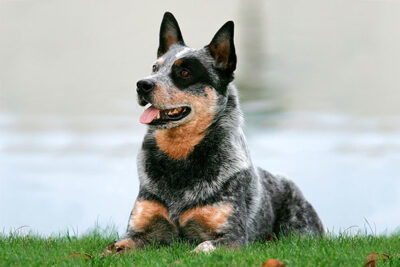

Australian-Kelpie
89.50% simliar to Australian-Cattle-Dog


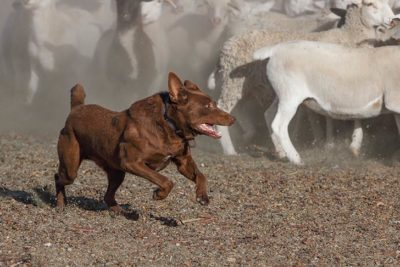

Catahoula-Leopard-Dog
75.83% simliar to Australian-Cattle-Dog


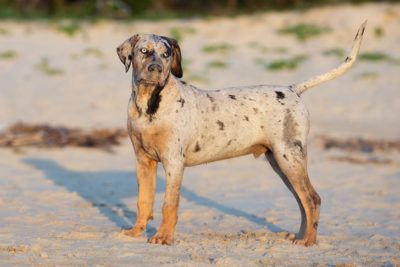

Bavarian-Mountain-Scent-Hound
73.69% simliar to Australian-Cattle-Dog


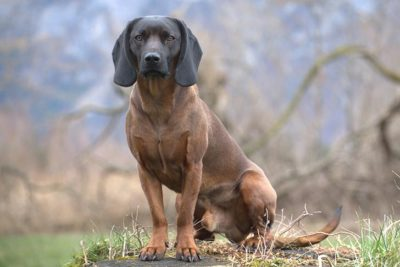

Berger-Picard
68.75% simliar to Australian-Cattle-Dog


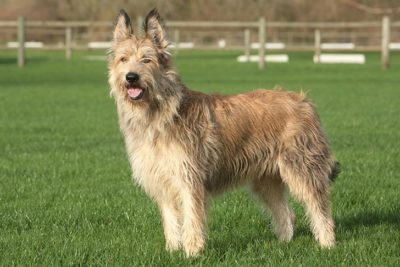

Basenji
68.47% simliar to Australian-Cattle-Dog


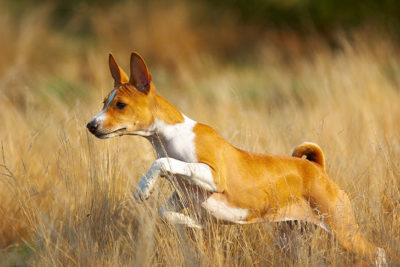

In [23]:
euclidean_by_name(df,"Australian-Cattle-Dog")

In [24]:
print(df_euclidean['height_c'].min(),df_euclidean['height_c'].max(),df_euclidean['weight_c'].min(),df_euclidean['weight_c'].max(),df_euclidean['life_c'].min(),df_euclidean['life_c'].max())

6.5 32.0 5.0 195.0 6.5 18.0


In [25]:
# recommendation based on the answering the questions
questions = ['height_c', 'weight_c', 'life_c',
       'Coat_Length_c', 'Affectionate With Family',
       'Good With Young Children', 'Good With Other Dogs', 'Shedding Level',
       'Coat Grooming Frequency', 'Drooling Level', 'Openness To Strangers',
       'Playfulness Level', 'Watchdog/Protective Nature', 'Adaptability Level',
       'Trainability Level', 'Energy Level', 'Barking Level',
       'Mental Stimulation Needs']
height = float(input("how do you want the height to be(in inches) 6.5 -> 32.0 : "))
height = (height - 6.5) / 32.0
weight = float(input("how do you want the weight to be(in pounds) 5.0 -> 195: "))
weight = (weight - 5) / 195
life = float(input("how long do you want them to live(in years) : "))
life = (life - 6.5)/ 18
coat = float(input("short, medium, long 1/2/3: ")) 
coat = (coat - 1)/3
affection = float(input("ind or lovey-dovey 1->5: "))
affection = (affection - 1) / 5
goodwkid = float(input("good with kid, not recommended to good 1->5: "))
goodwkid = (goodwkid - 1) / 5
goodwdog = float(input("good with other dog, not recommended to good 1->5: "))
goodwdog = (goodwdog - 1) / 5
shedding = float(input("no shedding to a lot of hair 1->5: "))
shedding = (shedding - 1) / 5
grooming = float(input("grooming, monthly to daily 1->5: "))
grooming = (grooming - 1) / 5
drooling = float(input("no drooling to have towel 1 -> 5: "))
drooling = (drooling - 1) / 5
opentostranger = float(input("reserved to open to every one 1->5: "))
opentostranger = (opentostranger - 1) / 5
playfulness = float(input("only when you want to play to Non-stop 1 ->5 :"))
playfulness = (playfulness - 1) / 5
watchdog = float(input("peaceful to watchdog 1 ->5: "))
watchdog = (watchdog - 1) / 5
adaptibility = float(input("routine needed to highly adaptable 1 ->5: "))
adaptibility = (adaptibility - 1) / 5
trainability = float(input("easy to train to difficult to train 1 -> 5: "))
trainability = (trainability - 1) / 5
energy = float(input("easy going to need to run every single second 1->5 :"))
energy = (energy - 1) / 5
barking = float(input("queit dog to loud dog: "))
barking = (barking - 1) / 5
mental = float(input("easy going to need a job asap: 1-> 5: "))
mental = (mental - 1) / 5
profile = [height, weight,life, coat, affection, goodwkid,goodwdog,shedding,grooming,drooling,opentostranger,playfulness,watchdog,adaptibility,trainability,energy,barking,mental]

# get the input and standardize them based on the previously defined largest and smallest value


Chow-Chow
53.42% matching with profile


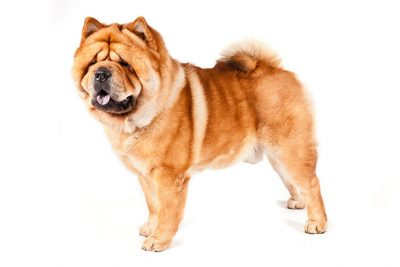

Croatian-Sheepdog
47.79% matching with profile


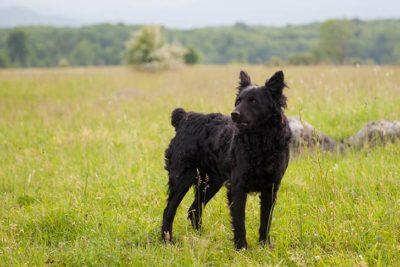

Bergamasco-Sheepdog
47.53% matching with profile


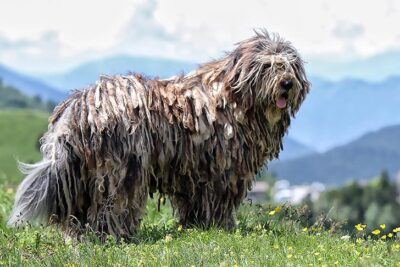

Deutscher-Wachtelhund
47.06% matching with profile


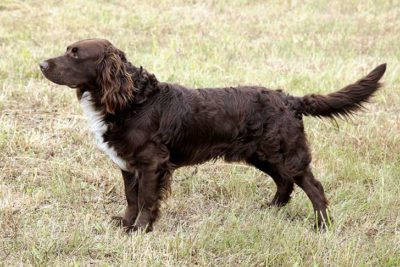

Central-Asian-Shepherd-Dog
46.91% matching with profile


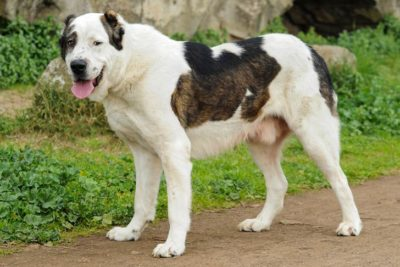

In [26]:
def get_names(df,profile):
    dist_list = []
    for i in range(df.shape[0]):
        dist_list.append(np.linalg.norm(profile-normalized_df_euclidean.iloc[i]))
    idx_list = sorted(range(len(dist_list)), key=lambda i: dist_list[i], reverse=False)[:5]
    return df['dog'][idx_list], 1- (sorted(dist_list)[0:5] / sorted(dist_list)[-1])

def euclidean_by_profile(df, profile):
    name_list, dis = get_names(df,profile)
    for name,d in zip(name_list,dis):
        print(name)
        print(format(d,'.2%'), "matching with profile")
        display(Image(filename=f'img/{name}.jpg'))

euclidean_by_profile(df,profile)

In [27]:
df_pca = df.drop(['breed_info', 'health', 'grooming', 'excercise', 'training', 'nutrition'], axis =1) # drop columns with text

print(df_pca.shape)
df_pca.dropna(inplace = True)
print(df_pca.shape)

(276, 21)
(180, 21)


In [29]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_pca.drop(['dog','coat_c'], axis = 1))

In [30]:

kmeans = KMeans(
    init="random",
     n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42 )
kmeans.fit(scaled_data)

KMeans(init='random', n_clusters=3, random_state=42)

[0.2132907  0.15888459]


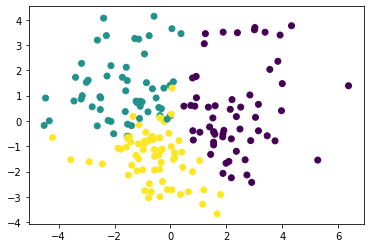

In [31]:
pca = PCA(n_components=2)
components = pca.fit_transform(scaled_data)
print(pca.explained_variance_ratio_)
plt.scatter(components[:,0],components[:,1], c= kmeans.labels_)

In [32]:
df1 = components
fig = px.scatter(df1, x=df1[:,0], y=df1[:,1], color = kmeans.labels_, hover_name = df_pca.dog)
fig.show()